In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Replace with your path!
!unzip -q "/content/drive/MyDrive/archive.zip" -d data

In [4]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/new.h5')

In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [7]:
BASE_DIR = '/content/data/UTKFace'

In [8]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [9]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head(10)

,image,age,gender
0,/content/data/UTKFace/34_1_1_20170113001015235...,34,1
1,/content/data/UTKFace/53_1_1_20170113001807851...,53,1
2,/content/data/UTKFace/30_0_4_20170120133906735...,30,0
3,/content/data/UTKFace/22_0_2_20170104021125111...,22,0
4,/content/data/UTKFace/2_0_2_20170110212538628....,2,0
5,/content/data/UTKFace/70_0_0_20170117160051432...,70,0
6,/content/data/UTKFace/25_0_2_20161219193843611...,25,0
7,/content/data/UTKFace/27_0_4_20170117120137595...,27,0
8,/content/data/UTKFace/88_1_0_20170120225747122...,88,1
9,/content/data/UTKFace/29_1_2_20170116191209449...,29,1


In [10]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

In [11]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

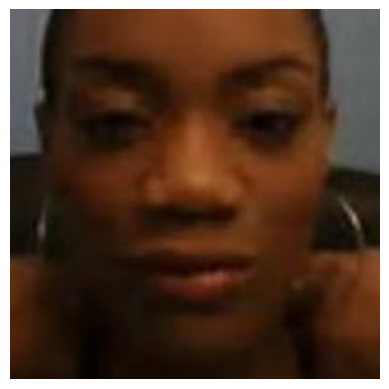

In [12]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

In [13]:
from tensorflow.keras.preprocessing.image import load_img
from tqdm import tqdm
import numpy as np

def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

X = extract_features(df['image'])

100%|██████████| 23708/23708 [00:55<00:00, 427.99it/s]


In [14]:
X.shape

# normalize the images
X = X/255.0

In [15]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [16]:
input_shape = (128, 128, 1)

In [17]:
import cv2

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Bidirectional, LSTM, LayerNormalization, Attention, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy, MeanAbsoluteError
from tensorflow.keras.utils import plot_model

X_train, X_val, y_train_gender, y_val_gender, y_train_age, y_val_age = train_test_split(
    X, y_gender, y_age, test_size=0.2, random_state=42)

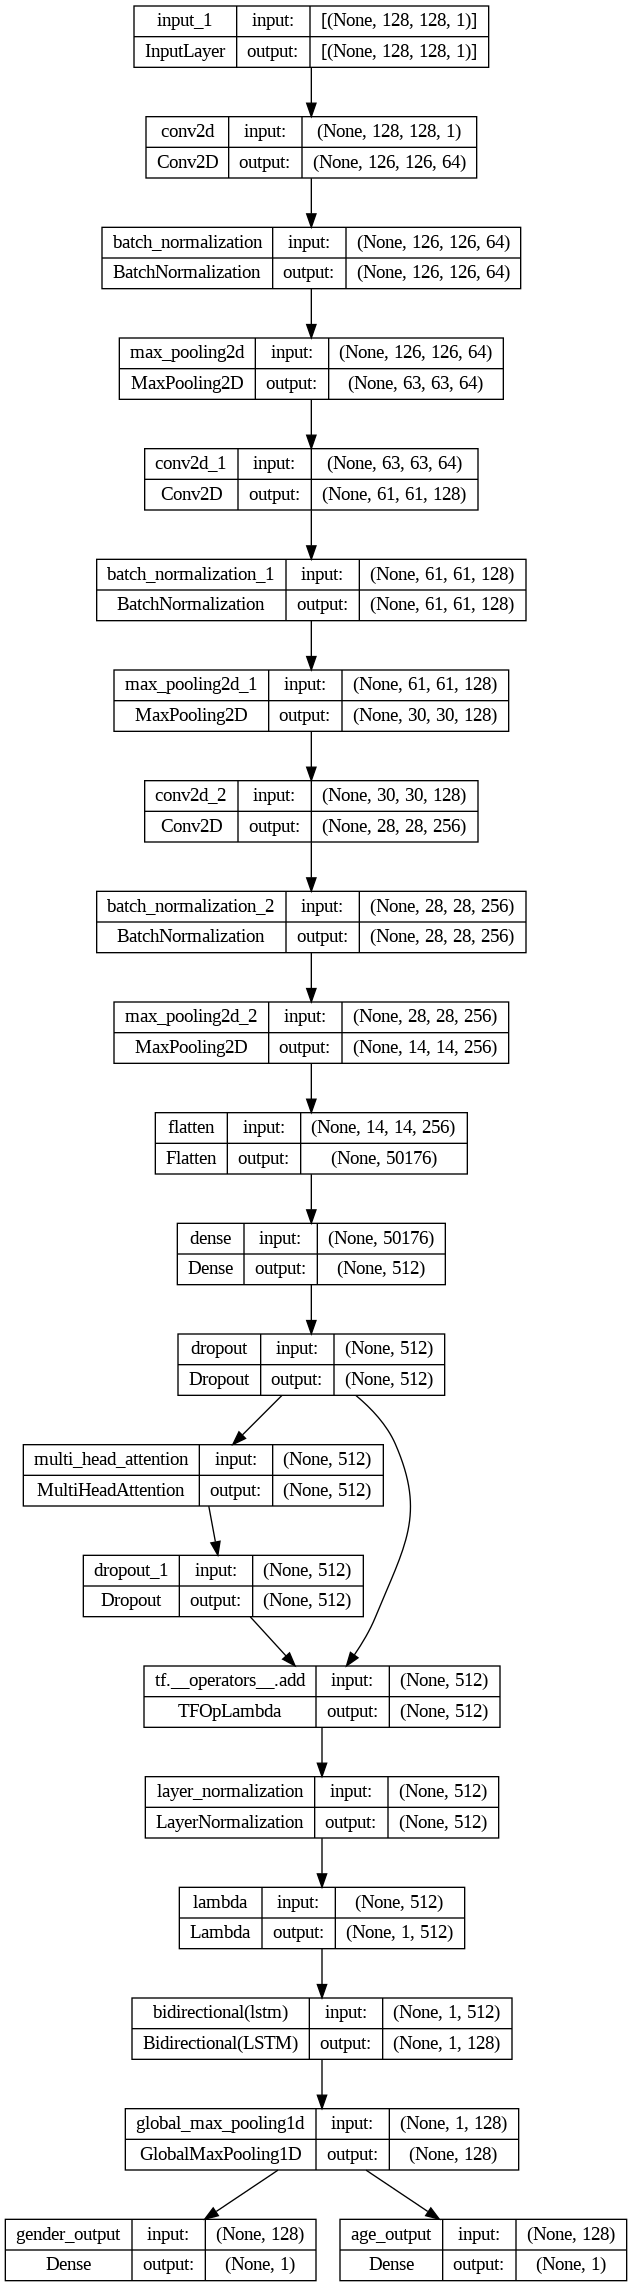

In [19]:
# Plot the model architecture
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [20]:
# Evaluate the model
metrics = model.evaluate(X_val, {'gender_output': y_val_gender, 'age_output': y_val_age})

# Extract metrics for gender output
if isinstance(metrics, list):
    gender_loss = metrics[0]
    gender_accuracy = None
else:
    gender_loss = metrics['gender_output_loss']
    gender_accuracy = metrics['gender_output_accuracy']


# Extract metrics for age output
age_loss = metrics[0] if isinstance(metrics, list) else metrics['age_output_loss']
age_mae = metrics[1] if isinstance(metrics, list) else metrics['age_output_mean_absolute_error']
age_mse = metrics[2] if isinstance(metrics, list) else metrics['age_output_mean_squared_error']

# Calculate total loss explicitly
total_loss = gender_loss + age_loss

# Print the evaluation results
print("Total Loss:", total_loss)
print("Gender Loss:", gender_loss)
print("Age Loss:", age_loss)
print("Gender Accuracy:", gender_accuracy)
print("Age MAE:", age_mae)
print("Age MSE:", age_mse)

149/149 [==============================] - 142s 938ms/step - loss: 6.7010 - gender_output_loss: 0.6201 - age_output_loss: 6.0809 - gender_output_accuracy: 0.6655 - age_output_mae: 6.0809
Total Loss: 13.40191650390625
Gender Loss: 6.700958251953125
Age Loss: 6.700958251953125
Gender Accuracy: None
Age MAE: 0.620071530342102
Age MSE: 6.0808868408203125


In [21]:
total_images = len(X_val)
mismatch_count = 0

for image_index in range(total_images):
    # Reshape the image data to match the input shape expected by the model
    image = X_val[image_index].reshape(1, 128, 128, 1)

    # Predict using the model
    pred = model.predict(image)

    # Extract predicted gender value
    pred_gender = gender_dict[round(pred[0][0][0])]

    # Check if the predicted gender is different from the original gender
    if pred_gender != gender_dict[y_val_gender[image_index]]:
        mismatch_count += 1

gender_accuracy = (total_images - mismatch_count) / total_images
print("Gender accuracy for all images:", gender_accuracy)


1/1 [==============================] - 0s 58ms/step
Gender accuracy for all images: 0.6655419654154365
